# Tugas Besar Data Mining <br>
Nama : Marcello Rasel Hidayatullah <br>
NIM  : 1301184019

Tugas Besar Data Mining ini membuat sistem rekomendasi buku dengan 2 skenario. Skenario pertama yaitu dengan Collaborative Filtering dan skenario kedua yaitu Clustering.

## Import Libraries dan Dataset

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [ ]:
df_items = pd.read_csv('items.csv',sep="|")
df_transactions = pd.read_csv('transactions.csv',sep="|")

In [ ]:
df_items

,itemID,title,author,publisher,main topic,subtopics
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"
2,19194,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]"
3,40250,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]"
4,46107,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"[WD,WFTM,YBG,YBL,YBLD,YBLN1]"
...,...,...,...,...,...,...
78025,37678,Timeless Fairy Tales,"Brothers Grimm, Marie-Catherine Baroness D'Aulnoy",MEDIAMORPHOSIS,YFA,[YFJ]
78026,68688,Demon Games,A. Witt Timothy a. Witt,iUniverse,FMB,[]
78027,57291,Lori and the Lion's Den,A. M. Glass,Xlibris,YFU,[]
78028,78130,The Everywhere Armchair,Ersila Bee,ELOQUENT BOOKS,YFC,"[YFG,YFH]"


In [ ]:
df_transactions

,sessionID,itemID,click,basket,order
0,0,21310,1,0,0
1,1,73018,1,0,0
2,2,19194,1,0,0
3,3,40250,1,0,0
4,4,46107,1,0,0
...,...,...,...,...,...
365138,279351,70183,1,0,0
365139,279352,39716,1,0,0
365140,279353,35260,1,0,0
365141,279353,18805,4,0,0


## Data Exploration

In [ ]:
print(df_items.shape)
print(df_transactions.shape)

(78030, 6)
(365143, 5)


In [ ]:
len(df_items.title.unique())

72128

In [ ]:
len(df_items.itemID.unique())

78030

In [ ]:
len(df_transactions.sessionID.unique())

271983

In [ ]:
len(df_transactions.itemID.unique())

24909

## Collaborative Filtering

Ide dari Collaborative filtering yang dilakukan yaitu mencari 5 buku yang direkomendasikan berdasarkan judul buku yang dipilih. 5 buku yang direkomendasikan berdasarkan tetangga terdekat menggunakan K Nearest Neighbor.

### Preprocessing

Preprocessing yang dilakukan yaitu : <br>
1. Mengecek Missing Values.
2. Mengecek Duplicated data.<br>
Tidak dilakukan pre-processing teks seperti case folding, stemming, stop word removal, dan lainnya dikarenakan jika melakukan proses-proses tersebut dapat merubah isi kolom 'title'. 

Mengecek missing values.

In [ ]:
df_items.isnull().sum()

itemID           0
title            0
author        3240
publisher        9
main topic     258
subtopics        1
dtype: int64

In [ ]:
df_transactions.isnull().sum()

sessionID    0
itemID       0
click        0
basket       0
order        0
dtype: int64

Dikarenakan pada data items.csv terdapat missing values pada kolom author, publisher, main topic, dan subtopics maka keempat kolom tersebut diisi dengan nilai modus.

In [ ]:
df_items = df_items.fillna(df_items.mode().iloc[0])

In [ ]:
df_items.isnull().sum()

itemID        0
title         0
author        0
publisher     0
main topic    0
subtopics     0
dtype: int64

Mengecek Duplicate Data.

In [ ]:
df_items[df_items.duplicated(keep=False)]

,itemID,title,author,publisher,main topic,subtopics


In [ ]:
df_transactions[df_transactions.duplicated(keep=False)]

,sessionID,itemID,click,basket,order


In [ ]:
df_transactions[df_transactions.duplicated(['itemID'], keep=False)]

,sessionID,itemID,click,basket,order
0,0,21310,1,0,0
1,1,73018,1,0,0
2,2,19194,1,0,0
3,3,40250,1,0,0
4,4,46107,1,0,0
...,...,...,...,...,...
365138,279351,70183,1,0,0
365139,279352,39716,1,0,0
365140,279353,35260,1,0,0
365141,279353,18805,4,0,0


In [ ]:
df_transactions['itemID'].value_counts()

58522    2291
66247    1775
10666    1749
44220    1687
69185    1290
         ... 
43308       1
49629       1
32107       1
12739       1
69469       1
Name: itemID, Length: 24909, dtype: int64

In [ ]:
len(df_transactions['itemID'])

365143

In [ ]:
len(df_transactions.itemID.unique())

24909

In [ ]:
df_transactions[df_transactions.duplicated(['sessionID'], keep=False)]

,sessionID,itemID,click,basket,order
7,7,14576,1,1,0
8,7,17731,2,1,0
13,12,30277,1,0,0
14,12,29508,1,1,0
15,12,75659,1,0,0
...,...,...,...,...,...
365135,279350,73084,1,0,0
365136,279350,13996,1,0,0
365137,279350,23084,1,0,0
365140,279353,35260,1,0,0


In [ ]:
df_transactions['sessionID'].value_counts()

29304     213
95250     157
7394      144
218629    141
15327     129
         ... 
234710      1
232661      1
230612      1
244947      1
0           1
Name: sessionID, Length: 271983, dtype: int64

In [ ]:
len(df_transactions['sessionID'])

365143

In [ ]:
len(df_transactions.sessionID.unique())

271983

Tidak terdapat duplicate data pada kedua dataset, namun setelah mengecek kolom 'sessionID' pada dataset transactions.csv, terdapat duplicate data. Hal ini berarti pada  1 'sessionID' bisa memuat lebih dari 1 'itemID' atau 1 kali sesi transaksi terdapat lebih dari 1 item. Maka tidak dilakukan penghapusan duplicate.

### Data Preparation

Akan dipilih buku-buku yang memiliki nilai 'basket' atau buku yang dilihat setidaknya 1 buku untuk merekomendasikannya. Alasan memilih setidaknya nilai 'basket' = 1 karena tidak ingin merekomendasikan buku yang sekiranya kurang menarik. Lalu alasan pemilihan kolom 'basket' dikarenakan kolom tersebut berarti terdapat seseorang yang tertarik dengan suatu buku, walaupun buku tersebut belum dibeli namun dengan memasukkannya ke keranjang berarti buku tersebut telah menarik bagi orang tersebut.

In [ ]:
# Melihat jumlah nilai basket
df_transactions['basket'].value_counts()

0      320155
1       42193
2        2315
3         273
4          66
5          25
7          14
6          13
10         13
11          6
24          5
14          5
20          5
8           4
9           4
21          4
23          4
28          3
25          3
15          3
36          2
65          2
38          2
119         2
26          2
98          1
80          1
43          1
100         1
58          1
52          1
51          1
48          1
29          1
268         1
12          1
13          1
293         1
16          1
18          1
287         1
22          1
150         1
30          1
182         1
Name: basket, dtype: int64

Tahap pertama mengekstrak buku yang memiliki nilai 'basket' minimal 1 kali.

In [ ]:
total_basket = df_transactions['basket'].value_counts() > 0
basket = total_basket[total_basket].index 
print(basket.shape)

df_transactions = df_transactions[df_transactions['basket'].isin(basket)]

(45,)


Setelah dieksrak akan digabungkan kedua dataset berdasarkan 'itemID' dari tiap buku.

In [ ]:
df = df_transactions.merge(df_items, on='itemID')
df.head()

,sessionID,itemID,click,basket,order,title,author,publisher,main topic,subtopics
0,0,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
1,89272,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
2,183856,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
3,1,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"
4,771,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"


In [ ]:
df.shape

(365143, 10)

Setelah itu dilakukan ekstrak jumlah buku yang memiliki 'basket' minimal 1. Menghitung 'basket' setiap buku lalu mengelompokkan data berdasarkan judul dan basket.

In [ ]:
temp = df.groupby('title')['basket'].count().reset_index()
temp.rename(columns= {'basket':'Jumlah Basket Buku'}, inplace=True)

df_basket = df.merge(temp, on='title')
df_basket = df_basket[df_basket['Jumlah Basket Buku'] >= 1]
df_basket.drop_duplicates(['itemID','title'], inplace=True)

In [ ]:
df_basket.sort_values(by=['Jumlah Basket Buku'], ascending = False)

,sessionID,itemID,click,basket,order,title,author,publisher,main topic,subtopics,Jumlah Basket Buku
37829,184,58522,1,0,0,Harry Potter Box Set: The Complete Collection ...,Joanne K. Rowling,Bloomsbury UK,YFH,[YFB],2291
2249,16,15581,0,1,0,Der Herr der Ringe,J. R. R. Tolkien,Klett-Cotta Verlag,FMB,"[FYT,YFH]",2066
3971,1230,14442,1,0,0,Der Herr der Ringe,J.R.R. Tolkien,Klett-Cotta Verlag,FMB,[FYT],2066
3773,718,77619,1,0,0,Der Herr der Ringe,John R Tolkien,Klett-Cotta Verlag,FMB,"[FYT,YFH]",2066
3070,449,45332,1,0,0,Der Herr der Ringe,John Ronald Reuel Tolkien,Klett-Cotta Verlag,FMB,"[FB,FYT,YFH]",2066
...,...,...,...,...,...,...,...,...,...,...,...
354848,108585,14614,1,0,0,The Wind on the Moon,Eric Linklater,Vintage Publishing,YFA,[YFH],1
354847,108584,21736,1,0,0,Halayda,Sarah Delena White,Uncommon Universes Press,FM,[],1
354844,108579,44880,1,0,0,Mockingjay,Suzanne Collins,TURTLEBACK BOOKS,YFC,"[YFE,YFG]",1
354843,108536,50553,1,0,0,Sorrow,Zachary Weaver,Pitbull Publishing,FMX,[],1


In [ ]:
len(df_basket)

24909

Tahap selanjutnya adalah membuat tabel pivot.

In [ ]:
tabel_pivot = df_basket.pivot_table(columns='sessionID', index='title', values="Jumlah Basket Buku")
tabel_pivot.fillna(0, inplace=True)

In [ ]:
len(tabel_pivot)

23534

In [ ]:
tabel_pivot.head()

sessionID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,...,277025,277214,277336,277449,277473,277474,277487,277533,277606,277663,277788,277816,277819,277931,277951,278037,278264,278286,278376,278382,278410,278507,278681,278719,278741,278804,278850,278916,278923,278989,279032,279034,279044,279065,279161,279176,279210,279248,279343,279350
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
#Basteln for Future,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#Instacat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#Sticker for Future,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#Wir bleiben zuhause Kindermitmachbuch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#selbstschuld - Was heißt schon privat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Modelling

Sebelum memasukkan ke model, tabel pivot akan dikonversi ke matriks sparse.

In [ ]:
from scipy.sparse import csr_matrix
sparse = csr_matrix(tabel_pivot)

In [ ]:
sparse

<23534x21207 sparse matrix of type '<class 'numpy.float64'>'
	with 24791 stored elements in Compressed Sparse Row format>

### Book Recommendation

Setelah itu dapat dimasukkan ke model. Algoritma yang digunakan yaitu kNN brute dengan mencari 5 tetangga terdekat. Algoritma tersebut mencari jarak menggunakan euclidian distance untuk mencari jarak tiap titik ke titik lainnya.

In [104]:
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(n_neighbors=6, algorithm='brute')
model.fit(sparse)

NearestNeighbors(algorithm='brute', n_neighbors=6)

Setelah memasukkan ke model, maka dapat mencari suatu buku berdasarkan indeksnya. Di sini akan dicontohkan mencari buku dengan judul A Beautifully Foolish Endeavor yang berada pada indeks ke 183.

In [106]:
distances, suggestions = model.kneighbors(tabel_pivot.iloc[183, :].values.reshape(1, -1))

In [108]:
for i in range(len(suggestions.flatten())):
  if i == 0:
    print("Rekomendasi untuk buku {0}:\n".format(tabel_pivot.index[183]))
  else:
    print("{0}: {1}, dengan jarak {2}:".format(i, tabel_pivot.index[suggestions.flatten()[i]], distances.flatten()[i]))

Rekomendasi untuk buku A Beautifully Foolish Endeavor:

1: Die Magier des Horus, dengan jarak 8.54400374531753:
2: Polar Bear Babies Step Into Reading Lvl 1, dengan jarak 8.54400374531753:
3: Die Mannschaft der 1000 Gefahren, dengan jarak 8.54400374531753:
4: Pokémon Guía Definitiva de la Región Galar. Libro Oficial 2020. Pokémon Espada / Pokémon Escudo / Ha, dengan jarak 8.54400374531753:
5: Pokemon Adventures Collector's Edition, Vol. 8, dengan jarak 8.54400374531753:


Berdasarkan hasilnya, didapat 5 buku yang direkomendasikan sesuai dengan judul yang dicari, yaitu buku Die Magier des Horus, Polar Bear Babies Step Into Reading Lvl 1, Die Mannschaft der 1000 Gefahren, Pokémon Guía Definitiva de la Región Galar. Libro Oficial 2020. Pokémon Espada / Pokémon Escudo / Ha, dan buku Pokemon Adventures Collector's Edition, Vol. 8.

Di sini akan dicontohkan lagi mencari buku dengan judul The Owls of Blossom Wood: Save the Day yang berada pada indeks ke 20000.

In [109]:
distances, suggestions = model.kneighbors(tabel_pivot.iloc[20000, :].values.reshape(1, -1))

In [110]:
for i in range(len(suggestions.flatten())):
  if i == 0:
    print("Rekomendasi untuk buku {0}:\n".format(tabel_pivot.index[20000]))
  else:
    print("{0}: {1}, dengan jarak {2}:".format(i, tabel_pivot.index[suggestions.flatten()[i]], distances.flatten()[i]))

Rekomendasi untuk buku The Owls of Blossom Wood: Save the Day:

1: Pokémon Guía Definitiva de la Región Galar. Libro Oficial 2020. Pokémon Espada / Pokémon Escudo / Ha, dengan jarak 1.4142135623730951:
2: Polly Diamond and the Magic Book, dengan jarak 1.4142135623730951:
3: Die Magier des Horus, dengan jarak 1.4142135623730951:
4: Polar Bear Babies Step Into Reading Lvl 1, dengan jarak 1.4142135623730951:
5: Pokemon Pocket Puzzles, dengan jarak 1.4142135623730951:


Berdasarkan hasilnya, didapat 5 buku yang direkomendasikan sesuai dengan judul yang dicari, yaitu buku Pokémon Guía Definitiva de la Región Galar. Libro Oficial 2020. Pokémon Espada / Pokémon Escudo / Ha, Polly Diamond and the Magic Book, Die Magier des Horus, Polar Bear Babies Step Into Reading Lvl 1, dan Pokemon Pocket Puzzles.

## Clustering

Pada clustering, rekomendasi akan dikelompokkan berdasarkan title, main topic, dan subtopics.

### Pre-processing

Preprocessing yang dilakukan yaitu : <br>
1. Mendrop kolom yang tidak diperlukan. 
2. Mengatasi Duplicated data.   
3. Encode ke Numerical. <br>
4. Scalling. <br>
Tidak dilakukan handling missing values dikarenakan data untuk clustering akan didapat dari mencopy data yang telah dipreprocess pada Content-Based Filtering. 

In [ ]:
data = df
data.head()

,sessionID,itemID,click,basket,order,title,author,publisher,main topic,subtopics
0,0,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
1,89272,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
2,183856,21310,1,0,0,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
3,1,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"
4,771,73018,1,0,0,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"


In [ ]:
# Mendrop kolom selain kolom judul buku, main topic, dan subtopics
data = data.drop(columns=['sessionID'])
data = data.drop(columns=['click'])
data = data.drop(columns=['basket'])
data = data.drop(columns=['order'])
data = data.drop(columns=['author'])
data = data.drop(columns=['publisher'])

In [ ]:
data.head()

,itemID,title,main topic,subtopics
0,21310,Princess Poppy: The Big Mix Up,YFB,[5AH]
1,21310,Princess Poppy: The Big Mix Up,YFB,[5AH]
2,21310,Princess Poppy: The Big Mix Up,YFB,[5AH]
3,73018,Einfach zeichnen! Step by Step,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"
4,73018,Einfach zeichnen! Step by Step,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"


Mengecek Duplicated Data

In [ ]:
data[data.duplicated(keep=False)]

,itemID,title,main topic,subtopics
0,21310,Princess Poppy: The Big Mix Up,YFB,[5AH]
1,21310,Princess Poppy: The Big Mix Up,YFB,[5AH]
2,21310,Princess Poppy: The Big Mix Up,YFB,[5AH]
3,73018,Einfach zeichnen! Step by Step,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"
4,73018,Einfach zeichnen! Step by Step,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"
...,...,...,...,...
364949,58773,Sternenflug,FLS,[3MR]
364992,47540,Big Nate 07. Big Nate Lives it Up,YFQ,[X]
364993,47540,Big Nate 07. Big Nate Lives it Up,YFQ,[X]
365039,45442,"An Hobbit, pe, Eno ha Distro: The Hobbit in Br...",FMB,[]


Dikarenakan tidak menggunakan kolom sessionID, maka terdapat banyak duplicated data. Oleh karena itu row yang memiliki duplicated data akan dihapus.

In [ ]:
data = data.drop_duplicates()

In [ ]:
len(data)

24909

Encode to Numerical

In [ ]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = data.columns.values.tolist()
for col in features:
    if data[col].dtype in numerics: continue
    categorical_columns.append(col)

# Encoding Fitur Categorical
for col in categorical_columns:
    if col in data.columns:
        enco = LabelEncoder()
        enco.fit(list(data[col].astype(str).values))
        data[col] = enco.transform(list(data[col].astype(str).values))

In [ ]:
print(data.dtypes)

itemID        int64
title         int64
main topic    int64
subtopics     int64
dtype: object


Semua tipe data sudah berbentuk numerical

Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scalled_data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)

In [ ]:
scalled_data.head()

,itemID,title,main topic,subtopics
0,-0.803947,0.541709,0.760357,-1.201785
1,1.463338,-0.683540,-1.712696,-1.108054
2,-0.896729,0.594285,0.824096,-0.312301
3,0.026531,0.240207,0.556394,-1.821554
4,0.283348,0.217884,0.314188,0.647576


### Modelling

Akan mencoba mengcluster data tersebut menjadi 3 kluster.

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(3)
kmeans.fit(scalled_data)

KMeans(n_clusters=3)

In [ ]:
cls = kmeans.fit_predict(scalled_data)
cls

array([2, 0, 1, ..., 0, 2, 1], dtype=int32)

In [ ]:
cluster_data = scalled_data.copy()
cluster_data['Clusters'] = cls 

In [ ]:
cluster_data.head()

,itemID,title,main topic,subtopics,Clusters
0,-0.803947,0.541709,0.760357,-1.201785,2
1,1.463338,-0.683540,-1.712696,-1.108054,0
2,-0.896729,0.594285,0.824096,-0.312301,1
3,0.026531,0.240207,0.556394,-1.821554,2
4,0.283348,0.217884,0.314188,0.647576,1


In [ ]:
cluster_data['Clusters'].value_counts()

0    9918
2    7806
1    7185
Name: Clusters, dtype: int64

Jika membagi menjadi 3 cluster, hasil didapat sebagai :<br>
1. Cluster 0 berjumlah 9918 buku.
2. Cluster 1 berjumlah 7806 buku.
3. Cluster 2 berjumlah 7185 buku.

### Evaluation

Untuk mencari jumlah kluster terbaik akan digunakan WCSS dan Elbow Method.

Text(0, 0.5, 'WCSS')

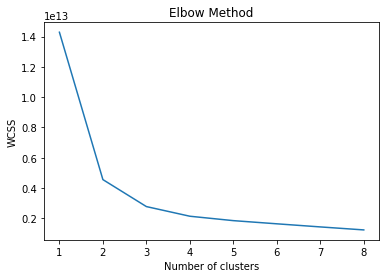

In [ ]:
wcss=[]
for i in range(1,9):
  kmeans=KMeans(i)
  kmeans.fit(data)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,9)
plt.plot(number_clusters,wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

Dati Elbow Method di atas, dapat dilihat bahwa patahan siku mulai menjadi paralel yaitu pada k = 3. Namun, akan dicoba untuk membagi data tersebut menjadi 4 kluster. Sebelum membaginya, akan dihitung nilai silhouette untuk k = 3.

In [ ]:
from sklearn.metrics import silhouette_score
print(f'Silhouette Score with 3 Clusters: {silhouette_score(scalled_data, cls)}')

Silhouette Score with 3 Clusters: 0.2570761475310102


Didapat nilai Silhouette = 0.257. Maka selanjutnya akan membagi data menjadi 4 kluster dan melihat nilai Silhouette nya.

In [ ]:
kmeans = KMeans(4)
kmeans.fit(scalled_data)

KMeans(n_clusters=4)

In [ ]:
cls = kmeans.fit_predict(scalled_data)
cls

array([1, 0, 2, ..., 3, 1, 2], dtype=int32)

In [ ]:
cluster_data = scalled_data.copy()
cluster_data['Clusters'] = cls 

In [ ]:
cluster_data.head()

,itemID,title,main topic,subtopics,Clusters
0,-0.803947,0.541709,0.760357,-1.201785,1
1,1.463338,-0.683540,-1.712696,-1.108054,0
2,-0.896729,0.594285,0.824096,-0.312301,2
3,0.026531,0.240207,0.556394,-1.821554,1
4,0.283348,0.217884,0.314188,0.647576,2


In [ ]:
cluster_data['Clusters'].value_counts()

1    7405
2    6397
0    6289
3    4818
Name: Clusters, dtype: int64

Jika membagi menjadi 4 cluster, hasil didapat sebagai :<br>
1. Cluster 0 berjumlah 6289 buku.
2. Cluster 1 berjumlah 7405 buku.
3. Cluster 2 berjumlah 6379 buku.
4. Cluster 3 berjumlah 4818 buku.

Nilai Silhouette pada k = 4 yaitu 0.2564, berarti nilai Silhouette k = 4 lebih kecil dibandingkan dengan k = 3, maka dapat disimpulkan bahwa jumlah kluster terbaik yaitu 3 kluster.

In [ ]:
from sklearn.metrics import silhouette_score
print(f'Silhouette Score with 4 Clusters: {silhouette_score(scalled_data, cls)}')

Silhouette Score with 4 Clusters: 0.25645493116628126
